In [329]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from l0bnb import fit_path
from sklearn import linear_model
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score)
from sklearn.metrics import (accuracy_score, mean_squared_error)
from sklearn.feature_selection import SequentialFeatureSelector
from ISLP import load_data
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression


# Question 8


### Simulate data

In [330]:
X = np.random.normal(loc=10, scale=1.5, size=100)
noise = np.random.normal(size=100)

B_0 = 2
B_1 = -3
B_2 = 6
B_3 = -4

# Create feuture and response
Y = B_0 + B_1 * X + B_2 * X**2 + B_3 * X**3 + noise
X = pd.DataFrame({f"X^{i}": X**i for i in range(1, 11)})

### Perform forward stepwise selection

In [331]:
# Estimate sigma2
full_model = linear_model.LinearRegression().fit(X, Y)
Y_pred_full = full_model.predict(X)
residuals = Y - Y_pred_full
sigma2_estimate = mean_squared_error(Y, Y_pred_full)

# Create scorer
def mallow_cp(estimator, X, y):
    """Mallows' Cp statistic."""
    n, p = X.shape
    y_pred = estimator.predict(X)
    RSS = np.sum((y - y_pred) ** 2)
    global sigma2_estimate
    return np.negative((RSS + 2 * p * sigma2_estimate) / n)

# Forward selection
stepwise_forward = SequentialFeatureSelector(
    linear_model.LinearRegression(),
    scoring=mallow_cp
)

stepwise_forward.fit(X, Y)
selected_features = X.columns[stepwise_forward.get_support()]
print(f"Selected features: {selected_features.tolist()}")

Selected features: ['X^1', 'X^2', 'X^3', 'X^4', 'X^10']


### Backward Selection 

Same result as forward.

In [332]:
# Forward selection
stepwise_backward = SequentialFeatureSelector(
    linear_model.LinearRegression(),
    direction='backward',
    scoring=mallow_cp
)

stepwise_backward.fit(X, Y)
selected_features = X.columns[stepwise_forward.get_support()]
print(f"Selected features: {selected_features.tolist()}")

Selected features: ['X^1', 'X^2', 'X^3', 'X^4', 'X^10']


### Lasso

In [333]:
# Define the LassoCV model
lasso_cv = linear_model.LassoCV(cv=5, random_state=0)

# Fit the model
lasso_cv.fit(X, Y)

# Print the optimal alpha value found by cross-validation
print(f"Optimal alpha (lambda) value: {lasso_cv.alpha_}")

# Use the optimal alpha to fit the final Lasso model
lasso = linear_model.Lasso(alpha=lasso_cv.alpha_)
lasso.fit(X, Y)

# Print the coefficients
print(f"Coefficients: {lasso.coef_}")

Optimal alpha (lambda) value: 87417520130.49315
Coefficients: [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -2.11317320e-06  1.21079319e-07]


# Question 9

### Split the data into test and train

In [334]:
# Get data
df = pd.DataFrame(load_data("College"))
# Convert "Private" column to numerical values
df["Private"] = df["Private"].astype("category").cat.codes

y = df["Apps"]
X = df.drop(columns="Apps")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

### fit OLS

In [335]:
# Fit
linReg = linear_model.LinearRegression()
linReg.fit(X_train, y_train)

# Find test error
predicts = linReg.predict(X_test)
mse_ols = mean_squared_error(y_test, predicts)
print(f"Mean Squared Error: {mse_ols}")

Mean Squared Error: 1775604.0090834824


### Ridge regression

In [336]:
# Fit ridge with K-fold cv
rid_cv = linear_model.RidgeCV(cv=5)
rid_cv.fit(X_train, y_train)

# Find test error
predicts = rid_cv.predict(X_test)
mse_rid = mean_squared_error(y_test, predicts)
print(f"Mean Squared Error: {mse_rid}")

Mean Squared Error: 1774949.8442924917


### Lasso

In [337]:
# Fit lasso with K-fold cv
las_cv = linear_model.LassoCV(cv=5)
las_cv.fit(X_train, y_train)

# Find test error
predicts = las_cv.predict(X_test)
mse_rid = mean_squared_error(y_test, predicts)
num_features_in_use = np.sum(las_cv.coef_ != 0)
print(f"Mean Squared Error: {mse_rid}")
print(f"Number of features in use: {num_features_in_use}")

Mean Squared Error: 2039143.1779619863
Number of features in use: 6


### PCR

In [338]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("linear", linear_model.LinearRegression()),
    ]
)

params = {
    "pca__n_components": list(range(1, min(X_train.shape[0], X_train.shape[1]) + 1))
}

grid_search = GridSearchCV(
    pipe, param_grid=params, cv=5, scoring="neg_mean_squared_error"
)
grid_search.fit(X_train, y_train)


predicts = grid_search.predict(X_test)
mse_pcr = mean_squared_error(y_test, predicts)
print(f"Mean Squared Error: {mse_pcr}")
print(
    f"Best number of components: {grid_search.best_estimator_.named_steps['pca'].n_components}"
)

Mean Squared Error: 1775604.0090834817
Best number of components: 17


In [339]:
M_values = list(range(1, min(X_train.shape[0], X_train.shape[1]) + 1))

best_score = float("inf")
best_M = None

for M in M_values:
    pls = PLSRegression(n_components=M)
    score = -np.mean(
        cross_val_score(pls, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    )

    if score < best_score:
        best_score = score
        best_M = M

pls_best = PLSRegression(n_components=best_M)
pls_best.fit(X_train, y_train)

predicts_pls = pls_best.predict(X_test)
mse_pls = mean_squared_error(y_test, predicts_pls)
print(f"Mean Squared Error for PLS: {mse_pls}")
print(f"Best M value selected by cross-validation: {best_M}")

Mean Squared Error for PLS: 1775604.0090834836
Best M value selected by cross-validation: 17


# Question 10

### Simulate

In [365]:
n = 1000
p = 20

X = np.random.normal(20, 12, (n, p))

for i in np.random.randint(0, 19, 4):
    X[i] = X[i]**2

for i in np.random.randint(0, 19, 4):
        X[i] = X[i]**3

for i in np.random.randint(0, 19, 4):
        X[i] = np.log(np.abs(X[i]))

beta = np.random.uniform(-100, 10, p)
for i in np.random.randint(0, 19, 7):
    beta[i] = 0

epsilon = np.random.normal(0, 1, n)

y = np.dot(X, beta) + epsilon

### Split into training and test

In [366]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=42
)

### Best subset selection

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  3
Iteration: 4. Number of non-zeros:  4
Iteration: 5. Number of non-zeros:  6
Iteration: 6. Number of non-zeros:  6
Iteration: 7. Number of non-zeros:  7
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  10
Iteration: 14. Number of non-zeros:  10
Iteration: 15. Number of non-zeros:  10
Iteration: 16. Number of non-zeros:  10
Iteration: 17. Number of non-zeros:  10
Iteration: 18. Number of non-zeros:  10
Iteration: 19. Number of non-zeros:  10
Iteration: 20. Number of non-zeros:  10
Iteration: 21. Number of non-zeros:  10
Iteration: 22. Number of non-zeros:  10
Iteration: 23. Number of non-zeros:  10
Iteration: 24. Number of non-zeros:  10
Iteration: 25. Number of non

In [372]:
help(fit_path)


Help on function fit_path in module l0bnb.regpath:

fit_path(x, y, lambda_2=0.01, max_nonzeros=10, intercept=True, normalize=True, m_multiplier=1.2, lambda_0_grid=None, lambda_0_grid_warm_start=None, gap_tol=0.01, time_limit=86400, solver='l0bnb')
    Solves the L0L2-regularized least squares problem over a sequence of
    lambda_0's.
    
    Note:
        By default, the sequence of lambda_0's is automatically selected by the
        toolkit such that the number of nonzeros varies between 1 and
        max_nonzeros. The parameters max_nonzeros and lambda_2 should be
        specified by the user.
    
    Inputs:
        x (numpy array): The data matrix.
        y (numpy array): The response vector.
        lambda_2 (float): The ridge regularization parameter.
        max_nonzeros (int): The maximum number of nonzeros to terminate the
            regularization path at.
        intercept (bool): If True, adds an intercept term to the regression
            model. Defaults to True.
  

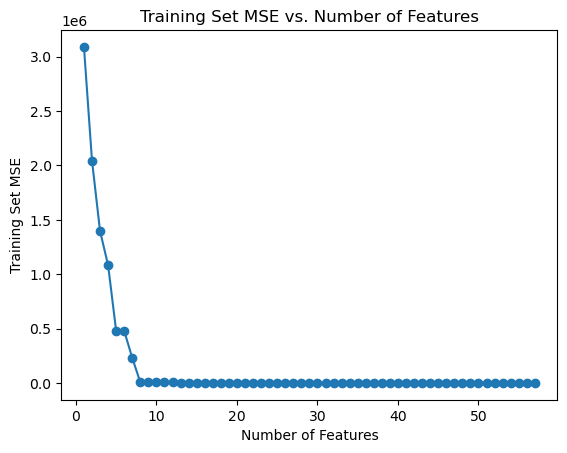

In [368]:
mse_train = []
for M in path:
    preds = M['B0'] + np.dot(X_train, M['B'])
    mse = mean_squared_error(y_train, preds)
    mse_train.append(mse)

plt.plot(range(1, len(mse_train) + 1), mse_train, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Training Set MSE')
plt.title('Training Set MSE vs. Number of Features')
plt.show()

### MSE vs. Features test

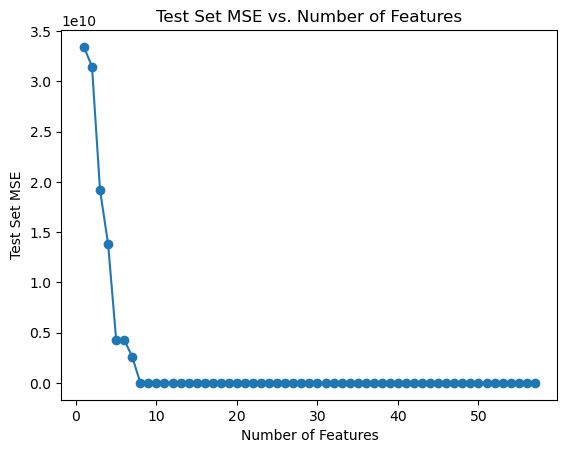

In [369]:
mse_test = []
for M in path:
    preds = M['B0'] + np.dot(X_test, M['B'])
    mse = mean_squared_error(y_test, preds)
    mse_test.append(mse)

plt.plot(range(1, len(mse_test) + 1), mse_test, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Test Set MSE')
plt.title('Test Set MSE vs. Number of Features')
plt.show()

In [ ]:
np.min(mse_test)
